# Real Business Cycle model

Below, we want to solve the following RBC model:

$$\max_{c_t, L_t, K_{t+1}} U = \frac{c_t^{1-\mu}}{1-\mu} - \psi \frac{L_t^{1+\eta}}{1+\eta} \\
\textrm{s.t.} \quad c_t + K_{t+1} = A_t K_t^{\alpha} L_t^{1-\alpha} + (1-\delta)K_t$$

This is the centralized solution to the RBC. Since the first welfare theorem applies here, we can use the centralized version to make the maths simpler. We can build the lagrangian:

$$L = \sum_{t=0}^{\infty} \beta^t \Big(\frac{c_t^{1-\mu}}{1-\mu} - \psi \frac{L_t^{1+\eta}}{1+\eta} + \lambda_t \big[A_t K_t^{\alpha} L_t^{1-\alpha} + (1-\delta)K_t - c_t - K_{t+1} \big] \Big)$$

The optimization results in the following first order conditions:

$$\frac{\partial L}{\partial c_t} = 0 \Leftrightarrow c_t^{-\mu} = \lambda_t \\
\frac{\partial L}{\partial L_t} = 0 \Leftrightarrow \psi L_t^{\eta} = \lambda_t (1-\alpha) A_t K_t^\alpha L_t^{-\alpha}$$

We can combine these two expressions to receive intratemporal optimality condition for the leisure-consumption allocation. Since we specify the utiltiy directly in terms of labor input, the trade-off is between consumption and labor, however, the intutition remains intact.

$$\psi L_t^{\eta} = c_t^{-\mu}(1-\alpha) A_t K_t^\alpha L_t^{-\alpha}$$

We can simplify the expression as follows:

$$L_t = \Big[\frac{c_t^{-\mu}(1-\alpha) A_t K_t^\alpha}{\psi}\Big]^{\frac{1}{{\eta+\alpha}}} $$

We can use the budget restriction and solve it for $L_t$, as well to receive $L_t = \Big[ \frac{c_t + K_{t+1} - (1-\delta)K_t}{A_tK_t^\alpha} \Big]^{\frac{1}{1-\alpha}}$. We equate the two expressions and implicitly define the optimal level of consumption from the optimization as a function of $K_t$, $A_t$, and $K_{t+1}$. We can use this expression to extract our consumption level for the defined state variables. Then we use the first order condition to extract labor supply, and finally to compute the overall utility. We write utility directly as a function of only consumption, using the first order condition:

$$U = \frac{c_t^{1-\mu}}{1-\mu} - \psi \frac{\Big(\big[\frac{c_t^{-\mu}(1-\alpha) A_t K_t^\alpha}{\psi}\big]^{\frac{1}{{\eta+\alpha}}}\Big)^{1+\eta}}{1+\eta} $$

With these conditions and expressions, we finally can setup the reward array to solve for the value function and the optimal policy function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.optimize as opt
%matplotlib inline
import quantecon as qe
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP

In [2]:
class SimpleOG:

    def __init__(self, kmin = 60, kmax=100, a_size = 50, z_size = 5, alpha=0.4, beta=0.99, gamma=1, delta=0.019, psi=2.2, eta=1, rho = 0.95, sigma = np.sqrt(0.000049)):
        """
        Set up R, Q and β, the three elements that define an instance of
        the DiscreteDP class.
        
        M is the upper limit of the storage capacity.
        """
        
        self.kmin, self.kmax = kmin, kmax 
        self.alpha, self.beta, self.gamma = alpha, beta, gamma 
        self.delta, self.rho, self.sigma = delta, rho, sigma
        self.psi, self.eta = psi, eta
        self.sigmay = (sigma**2 / (1 - self.rho**2))**(1/2)
        
        self.a_size, self.z_size = a_size, z_size
        self.a_vals = np.linspace(self.kmin, self.kmax, a_size)
        self.mc = qe.markov.approximation.tauchen(self.rho, self.sigmay, n = self.z_size)
        self.pi = self.mc.P
        self.z_vals = np.transpose(self.mc.state_values)
        if self.z_size == 1:
            self.z_vals[0] = 0
        
        # Setting up the asset grid
        self.n = self.a_size * self.z_size
        
        # Building the matrix R and Q:
        self.Q = np.zeros((self.n, self.a_size, self.n))
        self.populate_Q()
        
        self.R = np.zeros((self.n, self.a_size))
        self.populate_R()

    
    def populate_R(self):
        n = self.a_size * self.z_size
        self.c = np.zeros((n,self.a_size))
        for s_i in range(n):
            a_i = s_i // self.z_size         # Division without remainder
            z_i = s_i % self.z_size          # Remainder
            a = self.a_vals[a_i]
            z = self.z_vals[z_i]

            for new_a_i in range(self.a_size):
                lhs = lambda c, A, K: (c**(-1/self.gamma)*(1-self.alpha)*A*K**(self.alpha)/self.psi)**(1/(self.eta+self.alpha))
                rhs = lambda c, A, K, K1: ((c + self.a_vals[K1]-(1-self.delta)*K)/(A*K**(self.alpha)))**(1/(1-self.alpha))
                self.res = lambda c: -lhs(c, np.exp(z), a) + rhs(c, np.exp(z), a, new_a_i)
                c = opt.fsolve(self.res, 10**(-4), xtol = 10**(-10))
                self.c[s_i, new_a_i] = c
                if c > 0:
                    if self.gamma != 1:
                        self.R[s_i, new_a_i] = (c**(1-1/self.gamma)-1)/(1-1/self.gamma) - self.psi*(lhs(c, np.exp(z), a)**(1+self.eta))/(1+self.eta) # Utility
                    else:
                        self.R[s_i, new_a_i] = np.log(c) - self.psi*(lhs(c, np.exp(z), a)**(1+self.eta))/(1+self.eta)
                else:
                    self.R[s_i, new_a_i] = -100000            # Setting the utility highly negative
                    

    def populate_Q(self):
        n = self.a_size * self.z_size
        for s_i in range(n):
            z_i = s_i % self.z_size                    
            for a_i in range(self.a_size):
                for next_z_i in range(self.z_size):
                    self.Q[s_i, a_i, a_i * self.z_size + next_z_i] = self.pi[z_i, next_z_i]

In [3]:
# Setting up the parameters
an = 100
kmax = 110
kmin = 10
z_size = 15
psi = 3

g = SimpleOG(kmin = kmin, kmax = kmax, z_size = z_size, a_size = an, psi = psi)

C:\Users\Fabio\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in power
C:\Users\Fabio\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Fabio\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in power


Instances of `DiscreteDP` are created using the signature `DiscreteDP(R, Q, β)`.

Let’s create an instance using the objects stored in `g`

In [4]:
ddp = qe.markov.DiscreteDP(g.R, g.Q, g.beta)

Now that we have an instance `ddp` of `DiscreteDP` we can solve it as follows

In [5]:
results = ddp.solve(method = "pi")

Let’s see what we’ve got here

In [6]:
results.num_iter

5

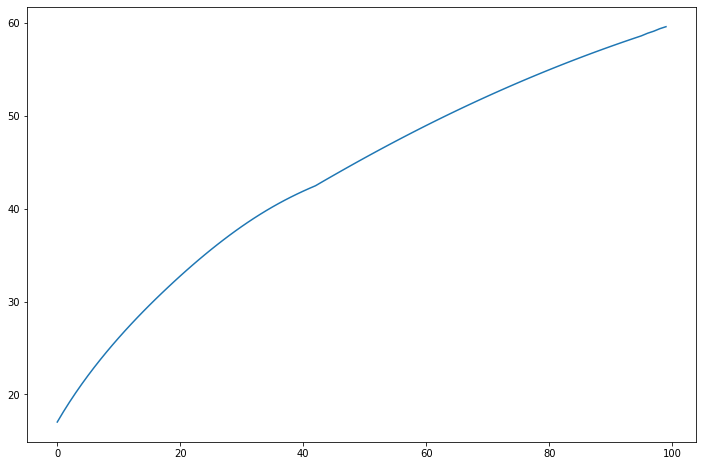

In [7]:
# Extracting the policy function
v = np.zeros((g.z_size, g.a_size))

n = g.z_size * g.a_size
for si in range(n):
    ai = si // g.z_size
    zi = si % g.z_size
    v[zi, ai] = results.v[si]

# Plotting the policy function
plt.subplots(figsize=(12,8))
num = int((g.z_size-1)/2)
plt.plot(v[num])
plt.show()

In [8]:
# Extracting the policy function
sigma = results.sigma
sigma = sigma.reshape((g.z_size, g.a_size))

policy = np.empty((g.z_size, g.a_size))
policy1 = np.copy(policy)
n = g.z_size * g.a_size
for si in range(n):
    ai = si // g.z_size
    zi = si % g.z_size
    policy[zi, ai] = g.a_vals[results.sigma[si]]
    policy1[zi, ai] = results.sigma[si]

# Generating a capital grid
t = np.linspace(kmin,kmax,an)

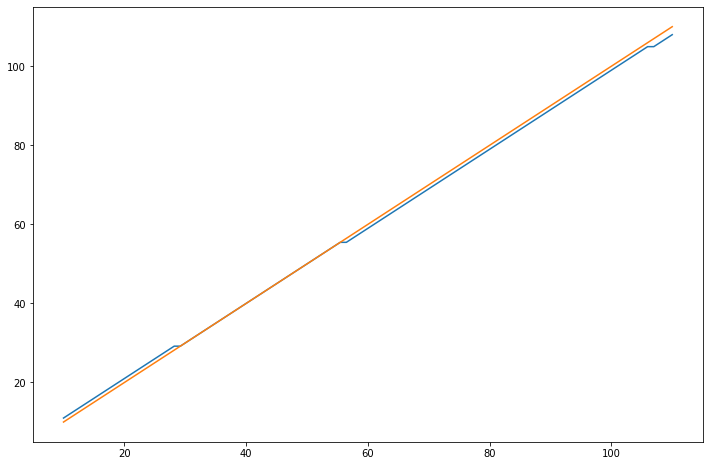

In [9]:
# Interpolate the policy function
t = np.linspace(kmin, kmax, an)
tck = interp.splrep(t, policy[num,:], k = 3)
y_app_spl = lambda x: interp.splev(x, tck)
excess = lambda x: y_app_spl(x) - x

# Plotting the relations
plt.subplots(figsize=(12,8))
plt.plot(t, y_app_spl(t))
plt.plot(t,t)
plt.show()

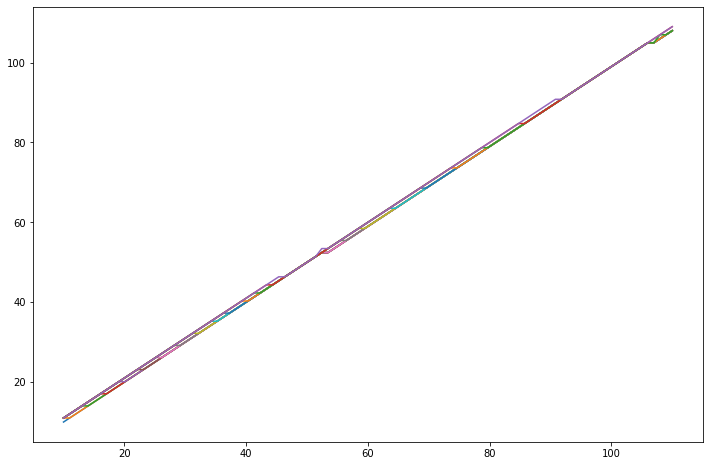

In [10]:
# Plot all policy functions together
plt.subplots(figsize=(12,8))
plt.plot(t, np.transpose(policy))
plt.show()

Let's now get the policy function for consumption.

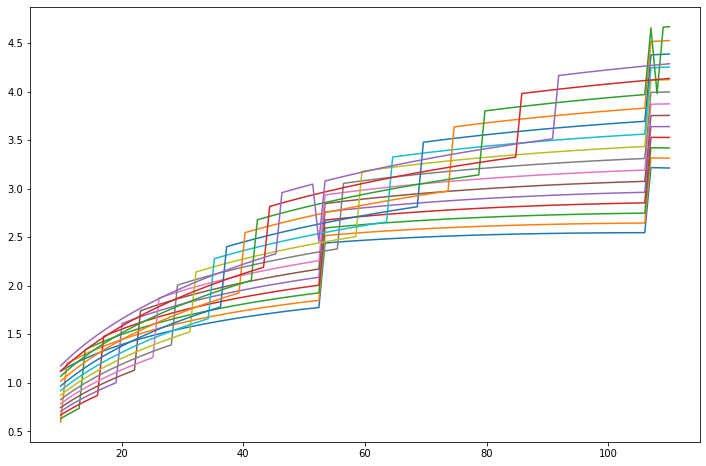

In [11]:
# Getting the policy function for consumption
polcon = np.zeros((g.z_size, g.a_size))
for i, s in enumerate(g.z_vals):
    for j, k in enumerate(g.a_vals):
        lhs = lambda c, A, K: (c**(-1/g.gamma)*(1-g.alpha)*A*K**(g.alpha)/g.psi)**(1/(g.eta+g.alpha))
        rhs = lambda c, A, K, K1: ((c + K1-(1-g.delta)*K)/(A*K**(g.alpha)))**(1/(1-g.alpha))
        res = lambda c: -lhs(c, np.exp(s), k) + rhs(c, np.exp(s), k, policy[i,j])
        polcon[i,j] = opt.fsolve(res, 10**(-4), xtol = 10**(-10))

        
# Plotting the policy function for consumption
plt.subplots(figsize=(12,8))
plt.plot(g.a_vals,np.transpose(polcon))
plt.show()

With the policy function for consumption, we can now extract the policy function for labor supply, as well.

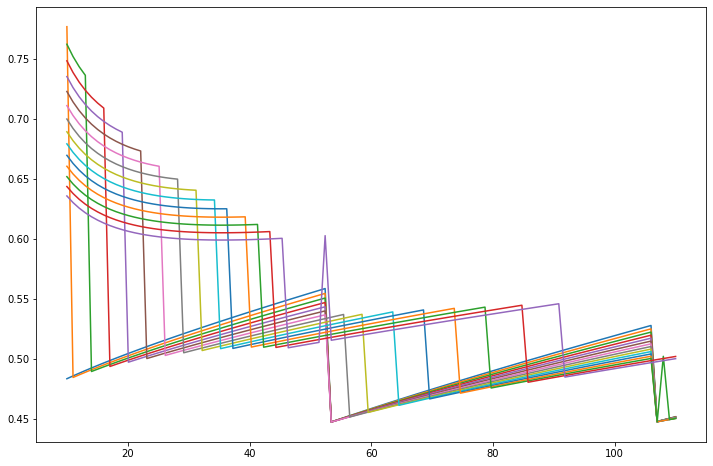

In [12]:
pollab = np.zeros((g.z_size, g.a_size))
for i, s in enumerate(g.z_vals):
    for j, k in enumerate(g.a_vals):
        lhs = lambda c, A, K: (c**(-1/g.gamma)*(1-g.alpha)*A*K**(g.alpha)/g.psi)**(1/(g.eta+g.alpha)) 
        pollab[i,j] = lhs(polcon[i,j], np.exp(s), k)
        
# Plotting the policy function for consumption
plt.subplots(figsize=(12,8))
plt.plot(g.a_vals,np.transpose(pollab))
plt.show()

Let's use the policy functions to simulate the economy.

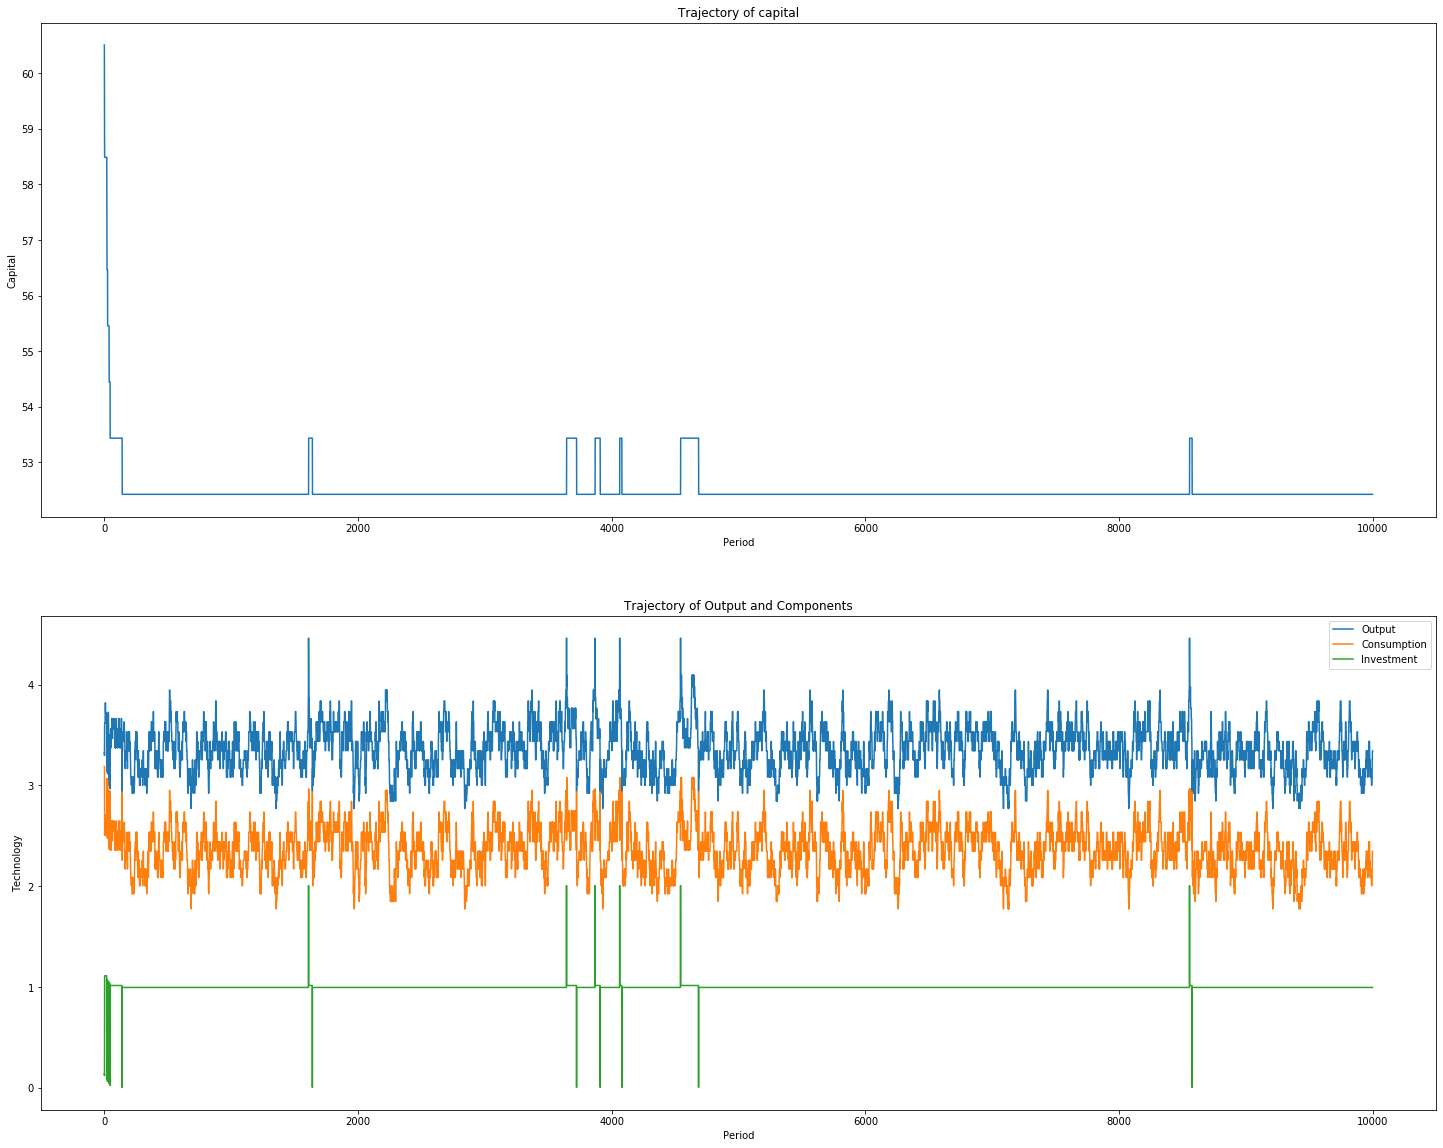

In [13]:
# Setting up arrays to store the results
T = 10000
cap0 = (kmax-kmin)/2 + kmin
index = int(an/(kmax-kmin)*(cap0-kmin))*g.z_size

# Simulating the time path
mc = qe.MarkovChain(g.pi, state_values=np.arange(g.z_size))
a_dev = mc.simulate(ts_length=T, init= int((g.z_size+1)/2))

cap1 = np.zeros((T))
cap = np.copy(cap1)
cap1[0] = int(index/g.z_size)
cap[0] = g.a_vals[int(cap1[0])]  

# Simulate the economy
for t in range(1,T):
    cap1[t] = policy1[int(a_dev[t-1]), int(cap1[t-1])]
    cap[t] = g.a_vals[int(cap1[t])]

lab = pollab[np.int16(a_dev), np.int16(cap1)]
out = np.exp(g.z_vals[a_dev])*cap**g.alpha*lab**(1-g.alpha)
cons = out - policy[np.int16(a_dev), np.int16(cap1)] + (1-g.delta)*cap
inv = out - cons

# Plotting the development
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(25,20))
axes[0].plot(cap)
axes[0].set_title("Trajectory of capital")
axes[0].set_xlabel("Period")
axes[0].set_ylabel("Capital")

axes[1].plot(out, label = "Output")
axes[1].plot(cons, label = "Consumption")
axes[1].plot(inv, label = "Investment")
axes[1].set_title("Trajectory of Output and Components")
axes[1].legend(loc=1)
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Technology")
plt.show()

Problematic is that we do not know the steady state in this case. The existence of labor supply distorts the optimal capital steady state, so we need to calculate it first. From the euler equation we get the optimal capital-labor ratio:

$$\frac{K}{L} = \Big[ \frac{\alpha \beta}{1-\beta(1-\delta)} \Big]^{\frac{1}{1-\alpha}}$$

From the intratemporal condition for the optimal allocation of consumption and leisure, we then can extract the equilibrium labor supply:

$$L = \Big[ \frac{c^{-\mu}(1-\alpha)(\frac{K}{L})^{\alpha}}{\psi} \Big]^{\frac{1}{\phi}}$$

With the equilibrium labor supply as a function of consumption, we now can write the optimal capital stock as a function of consumption. Last, we can implicitly define the steady state consumption as:

$$c + \delta K(c) = (\frac{K}{L})^\alpha L(c)$$

Given that capital and labor are a function of consumption, we can solve for their optimal value, as well.

In [14]:
# Extracting the parameters from the class
alpha = g.alpha
beta = g.beta
mu = 1/g.sigma
delta = g.delta
eta = g.eta               # Convexity of disutility
psi = g.psi               # Additive component
vega = 0.36

# Extracting the capital labor ratio
cl = ((alpha*beta)/(1-beta*(1-delta)))**(1/(1-alpha))

# Defining labor as a function of consumption
l = lambda c: ((c**(-mu)*(1-alpha)*cl**alpha)/psi)**(1/eta)


# Defining capital as a function of consumption
capc = lambda c: cl*l(c)

# Defining the residuals as a function of c:
res = lambda c: c + delta*capc(c) - cl**alpha * l(c)

# Extracting the steady state c using a root finding algorithm
cstar = opt.fsolve(res, 10**(-1/3))

print("\nSteady state consumption, capital and labor are %.5F, %.5F and %.5F." % (cstar[0], capc(cstar)[0], l(cstar)[0]))


Steady state consumption, capital and labor are 1.01106, 18.80951 and 0.23848.


Let's now compare our numerical steady state with the theoretical steady state.

In [15]:
print(np.mean(cons/out), np.mean(inv/out), np.mean(cap/out), np.mean(lab))

0.7025034734320861 0.297496526567914 15.675070398217613 0.5337651861218725
